# QBOi Tigramite notebook.

First attempt at a shared jupyter notebook.
- Install Tigramite and dependencies
- Load data from Dropbox
- Run Causal Effect Network analysis on QBOi data

All models are loaded, but currently some have errors in the v_flux timeseries.

Warning: Runtime type must be Python 2 (Python 3 not supported by Tigramite)

## Install dependencies and Tigramite
Use pip install to load cython and ace, then use pip install git+... to load tigramite directly from the github repo.

In [1]:
# Install tigramite dependencies
!pip install -q cython
!pip install -q ace

# Install other python modules
!pip install netcdf4
!pip install -U -q PyDrive


# Install Tigramite from github
!pip install git+https://github.com/jakobrunge/tigramite
  

    100% |████████████████████████████████| 81kB 5.0MB/s 
    100% |████████████████████████████████| 3.9MB 5.1MB/s 
    100% |████████████████████████████████| 286kB 28.0MB/s 
  Cloning https://github.com/jakobrunge/tigramite to /tmp/pip-req-build-TOr87w
  Stored in directory: /tmp/pip-ephem-wheel-cache-Uviqhl/wheels/b9/5d/5c/bd2c137dc0858cbf840aefa514061af5f6af7e863a2696b0de
Successfully built tigramite


In [2]:
# Imports required python packages
import numpy
import numpy.ma as ma
import matplotlib
from matplotlib import pyplot as plt
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb
from tigramite.models import LinearMediation, Prediction

import numpy as np
import pandas as pd
import netCDF4
from scipy import signal

# Import packages for PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client to save to google drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default() 
drive = GoogleDrive(gauth)


%matplotlib inline     




/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in loadNamespace(name) : there is no package called ‘RCIT’

  warnings.warn(x, RRuntimeWarning)


Could not import r-package RCIT


## Load data from Dropbox

I'm not sure if this is the best way to load data, but it's a start. Data is in csv format, the folder is not currently shared, I can give permissions if requested.

Unfortunately the file names aren't informative (i.e. no model, actor names etc.)

Each model has one csv file which contains 8 timeseries, one for each actor, plus a date column.

Note: Once analysis for the project is finalised, it might be good to move data to Figshare, so it has a stable address and DOI.

In [0]:
CAM = "https://www.dropbox.com/s/z7q0ut4ow5afv4m/CAM_QBOiExp1_r1i1p1_mon.csv?dl=1"
CCCmaCMAM = "https://www.dropbox.com/s/wqagtg6c9j7dbyz/CCCmaCMAM_QBOiExp1_r1i1p1_mon.csv?dl=1"
ISAC_CNRECHAM5sh = "https://www.dropbox.com/s/tngsg5rzgfyrce8/ISAC-CNRECHAM5sh_QBOiExp1_r1i1p1_mon.csv?dl=1"
MIROCMIROC_AGCM = "https://www.dropbox.com/s/7xtjtat587ruhg7/MIROCMIROC-AGCM_QBOiExp1_r1i1p1_mon.csv?dl=1"
MIROCMIROC_ESM = "https://www.dropbox.com/s/z5bld4yf01kg1yl/MIROCMIROC-ESM_QBOiExp1_r1i1p1_mon.csv?dl=1"
MOHCUMGA7 = "https://www.dropbox.com/s/eqe6lja4hqizz9e/MOHCUMGA7_QBOiExp1_r2i1p1_mon.csv?dl=1"
MRIMRI_ESM2 = "https://www.dropbox.com/s/h2j9p1mvbqsqcv2/MRIMRI-ESM2_QBOiExp1_r1i1p1_mon.csv?dl=1"
WACCM = "https://www.dropbox.com/s/d58qt9itu1cju34/WACCM_QBOiExp1_r1i1p1_mon.csv?dl=1"
YonseiHadGEM2_A = "https://www.dropbox.com/s/nmphfp14ibqydit/YonseiHadGEM2-A_QBOiExp1_r1i1p1_mon.csv?dl=1"
YonseiHadGEM2_AC = "https://www.dropbox.com/s/txbzedn5iqeewog/YonseiHadGEM2-AC_QBOiExp1_r1i1p2_mon.csv?dl=1"



Read data into Pandas dataframe

In [0]:
cam = pd.read_csv(CAM,index_col=0)
cccmacmam  = pd.read_csv(CCCmaCMAM,index_col=0)
isac_cnrecham5sh = pd.read_csv(ISAC_CNRECHAM5sh,index_col=0)
mirocmiroc_agcm = pd.read_csv(MIROCMIROC_AGCM,index_col=0)
mirocmiroc_esm = pd.read_csv(MIROCMIROC_ESM,index_col=0)
mohcumga7 = pd.read_csv(MOHCUMGA7,index_col=0)
mrimri_esm2 = pd.read_csv(MRIMRI_ESM2,index_col=0)
waccm = pd.read_csv(WACCM,index_col=0)
yonseihadgem2_a = pd.read_csv(YonseiHadGEM2_A,index_col=0)
yonseihadgem2_ac = pd.read_csv(YonseiHadGEM2_AC,index_col=0)


In [5]:
# Check the data

print("CAM")
print(cam.head(n=3))
print("CCCMA")
print(cccmacmam.head(n=3))
print("ISAC")
print(isac_cnrecham5sh.head(n=3))
print("MIROC AGCM")
print(mirocmiroc_agcm.head(n=3))
print("MIROC ESM")
print(mirocmiroc_esm.head(n=3))
print("MOHC")
print(mohcumga7.head(n=3))
print("MRI")
print(mrimri_esm2.head(n=3))
print("WACCM")
print(waccm.head(n=3))
print("Yonsei A")
print(yonseihadgem2_a.head(n=3))
print("Yonsei AC")
print(yonseihadgem2_ac.head(n=3))


CAM
                  date       NAO     BK-SIC     EA-tas        PoV        QBO  \
0  1979-01-01 00:00:00 -2.054485  251.47733  259.18082  20646.598  19.496222   
1  1979-02-01 00:00:00 -0.052400  253.90077  261.67360  20685.982   8.407872   
2  1979-03-01 00:00:00 -0.835044  252.33235  268.97030  20872.732   5.799190   

      Sib-SLP   Ural-SLP        v_flux  
0  102921.375  101529.72 -1.221974e+06  
1  102835.100  101082.43 -1.121744e+06  
2  102118.730  101041.84 -6.886762e+05  
CCCMA
                  date       NAO     BK-SIC     EA-tas        PoV        QBO  \
0  1979-01-16 12:00:00 -0.134571  255.85342  258.13870  49699.383  -2.074615   
1  1979-02-15 00:00:00 -1.028970  253.07300  256.22104  51511.902  11.060366   
2  1979-03-16 12:00:00 -0.449474  249.64914  263.97226  51703.230  13.727323   

      Sib-SLP   Ural-SLP       v_flux  
0  103267.000  101987.87  5833.113279  
1  103025.375  101946.29  9978.050677  
2  101817.020  101313.28  1610.895966  
ISAC
                  d

### Remove seasonal cycle and detrend

In [0]:

def rm_seascyc(df):
  """
  Remove seasonal cycle and detrend data from a pandas dataframe, 
  then return the anomaly dataframe 
  and a Tigramite dataframe
  """
  
  # Remove time of day from date
  df['date'] = pd.to_datetime(df['date'])
  df['date'] = df['date'].apply( lambda df : pd.datetime(year=df.year, 
                                                         month=df.month, 
                                                         day=df.day))

  # set date column as index
  df.set_index('date', inplace=True)

  # Create new column of months only
  df['mon'] = df.index.month

  # Get seasonal cycle, (transform keeps array the same size)
  seascyc = df.groupby('mon').transform('mean')

  # Remove seasonal cycle, create anomaly actors dataframe
  anomact = df - seascyc
  anomact.drop('mon',axis=1,inplace=True)


  #detrend data
  for colname, col in anomact.iteritems():
      # print(colname)
      anomact[colname] = signal.detrend(anomact[colname],axis=0)  

  #print(anomact.head(n=3))

  # Put data into tigramite dataframe

  var_names=anomact.keys()
  anomact_tdf = pp.DataFrame(anomact.as_matrix(columns=var_names[1::]))
  
  return anomact, seascyc

# Note: this doesn't work with NaN, still need to fix those models before doing this
cam_anom, cam_seascyc = rm_seascyc(cam)
cccmacmam_anom, cccmacmam_seascyc = rm_seascyc(cccmacmam)
isac_cnrecham5sh_anom, isac_cnrecham5sh_seascyc = rm_seascyc(isac_cnrecham5sh)
mirocmiroc_agcm_anom, mirocmiroc_agcm_seascyc = rm_seascyc(mirocmiroc_agcm)
mirocmiroc_esm_anom, mirocmiroc_esm_seascyc = rm_seascyc(mirocmiroc_esm)
mohcumga7_anom, mohcumga7_seascyc = rm_seascyc(mohcumga7)
mrimri_esm2_anom, mrimri_esm2_seascyc = rm_seascyc(mrimri_esm2)
waccm_anom, waccm_seascyc = rm_seascyc(waccm)
yonseihadgem2_a_anom, yonseihadgem2_a_seascyc = rm_seascyc(yonseihadgem2_a)
yonseihadgem2_ac_anom, yonseihadgem2_ac_seascyc = rm_seascyc(yonseihadgem2_ac)

# Fix differences in signs of actors
for rev_var in ['PoV']:
  #cam_anom[rev_var] = cam_anom[rev_var]*(-1)
  #cccmacmam_anom[rev_var] = cccmacmam_anom[rev_var]*(-1)
  isac_cnrecham5sh_anom[rev_var] = isac_cnrecham5sh_anom[rev_var]*(-1)
  #mirocmiroc_agcm_anom[rev_var] = mirocmiroc_agcm_anom[rev_var]*(-1)
  mirocmiroc_esm_anom[rev_var] = mirocmiroc_esm_anom[rev_var]*(-1)
  #mohcumga7_anom[rev_var] = mohcumga7_anom[rev_var]*(-1)
  #mrimri_esm2_anom[rev_var] = mrimri_esm2_anom[rev_var]*(-1)
  #waccm_anom[rev_var] = waccm_anom[rev_var]*(-1)
  #yonseihadgem2_a_anom[rev_var] = yonseihadgem2_a_anom[rev_var]*(-1)
  #yonseihadgem2_ac_anom[rev_var] = yonseihadgem2_ac_anom[rev_var]*(-1)
for rev_var in ['NAO']:
  cam_anom[rev_var] = cam_anom[rev_var]*(-1)
  cccmacmam_anom[rev_var] = cccmacmam_anom[rev_var]*(-1)
  #isac_cnrecham5sh_anom[rev_var] = isac_cnrecham5sh_anom[rev_var]*(-1)
  #mirocmiroc_agcm_anom[rev_var] = mirocmiroc_agcm_anom[rev_var]*(-1)
  #mirocmiroc_esm_anom[rev_var] = mirocmiroc_esm_anom[rev_var]*(-1)
  mohcumga7_anom[rev_var] = mohcumga7_anom[rev_var]*(-1)
  #mrimri_esm2_anom[rev_var] = mrimri_esm2_anom[rev_var]*(-1)
  waccm_anom[rev_var] = waccm_anom[rev_var]*(-1)
  #yonseihadgem2_a_anom[rev_var] = yonseihadgem2_a_anom[rev_var]*(-1)
  yonseihadgem2_ac_anom[rev_var] = yonseihadgem2_ac_anom[rev_var]*(-1)
for rev_var in ['v_flux']:
  cam_anom[rev_var] = cam_anom[rev_var]*(-1)
  #cccmacmam_anom[rev_var] = cccmacmam_anom[rev_var]*(-1)
  isac_cnrecham5sh_anom[rev_var] = isac_cnrecham5sh_anom[rev_var]*(-1)
  #mirocmiroc_agcm_anom[rev_var] = mirocmiroc_agcm_anom[rev_var]*(-1)
  mirocmiroc_esm_anom[rev_var] = mirocmiroc_esm_anom[rev_var]*(-1)
  #mohcumga7_anom[rev_var] = mohcumga7_anom[rev_var]*(-1)
  #mrimri_esm2_anom[rev_var] = mrimri_esm2_anom[rev_var]*(-1)
  #waccm_anom[rev_var] = waccm_anom[rev_var]*(-1)
  #yonseihadgem2_a_anom[rev_var] = yonseihadgem2_a_anom[rev_var]*(-1)
  #yonseihadgem2_ac_anom[rev_var] = yonseihadgem2_ac_anom[rev_var]*(-1)
  
  


## Create Month and QBO masks

In [0]:
# Mask data for QBOW, and create QBOW and QBOE dataframes

def qbomask(df_abs,df, u_lim=2):
  """
  Take a dataframe (df) with all timeseriees, put QBO into seperate df,
  make masks with the QBO data.
  Uses a threshold of +/- 5 m/s for u-wind, unless otherwise specified.
  Input: dataframe of anomalies
  Output: dataframe w/o QBO, df of QBO, mask for QBOE, mask for QBOW, 
          mask for no qbo, i.e. mask of months ONDJFM
  """

  # Put QBO timeseries in a seperate df and create QBOE/W df
  df_qbo = df_abs[['QBO']].copy()    # Use absolute values to calc QBO (not anom)
  df_noqbo = df.drop('QBO',axis=1)
  
  # Add month series
  df_noqbo['mon'] = df_noqbo.index.month
  
  # Set up masked arrays
  mask_qbow = np.zeros(df_qbo.shape).astype('bool')
  mask_qboe = np.zeros(df_qbo.shape).astype('bool')
  mask_mon = np.zeros(df_qbo.shape).astype('bool')

  # Create QBOW Mask for given u_lim
  mask_qbow = np.ma.masked_less(df_qbo.as_matrix(columns=['QBO']),u_lim).mask
  # Make mask same size as full df
  df_size = df_noqbo.shape[1]
  mask_qbow2 = np.tile(mask_qbow,df_size)
  # Repeat for QBOE
  mask_qboe = np.ma.masked_greater(df_qbo.as_matrix(columns=['QBO']),-u_lim).mask
  mask_qboe2 = np.tile(mask_qboe,df_size)

  # Create Mask for Months Oct-Mar (i.e. mask out all other months)
  mask_mon[:,0] = (
                  #(df_noqbo['mon'] == 1) | (df_noqbo['mon'] == 2) |
                  #(df_noqbo['mon'] == 3) | 
                  (df_noqbo['mon'] == 4) | (df_noqbo['mon'] == 5) |
                  (df_noqbo['mon'] == 6) | (df_noqbo['mon'] == 7) |
                  #(df_noqbo['mon'] == 10) | (df_noqbo['mon'] == 11) |
                  #(df_noqbo['mon'] == 12) | (df_noqbo['mon'] == 1) |
                  (df_noqbo['mon'] == 8) | (df_noqbo['mon'] == 9)
                  ).as_matrix()

  mask_mon2 = np.tile(mask_mon,df_size) #.reshape(mask_qboe2.shape)

  # Add month mask to QBO masks
  mask_qboe_mon = mask_qboe2 + mask_mon2
  mask_qbow_mon = mask_qbow2 + mask_mon2

  # Use QBO masks on data
#  df_qboe.mask(mask_qboe2,inplace=True)
#  df_qbow.mask(mask_qbow2,inplace=True)
  
  return(df_noqbo, df_qbo, mask_qboe_mon, mask_qbow_mon, mask_mon2)

cam_noqbo, cam_qbo, cam_qboe_mask, cam_qbow_mask, cam_noqbo_mask = qbomask(cam,cam_anom)
cccmacmam_noqbo, cccmacmam_qbo, cccmacmam_qboe_mask, cccmacmam_qbow_mask, cccmacmam_noqbo_mask = qbomask(cccmacmam, cccmacmam_anom)
isac_cnrecham5sh_noqbo, isac_cnrecham5sh_qbo, isac_cnrecham5sh_qboe_mask, isac_cnrecham5sh_qbow_mask, isac_cnrecham5sh_noqbo_mask = qbomask(isac_cnrecham5sh,isac_cnrecham5sh_anom)
mirocmiroc_agcm_noqbo, mirocmiroc_agcm_qbo, mirocmiroc_agcm_qboe_mask, mirocmiroc_agcm_qbow_mask, mirocmiroc_agcm_noqbo_mask = qbomask(mirocmiroc_agcm,mirocmiroc_agcm_anom)
mirocmiroc_esm_noqbo, mirocmiroc_esm_qbo, mirocmiroc_esm_qboe_mask, mirocmiroc_esm_qbow_mask, mirocmiroc_esm_noqbo_mask = qbomask(mirocmiroc_esm,mirocmiroc_esm_anom)
mohcumga7_noqbo, mohcumga7_qbo, mohcumga7_qboe_mask, mohcumga7_qbow_mask, mohcumga7_noqbo_mask = qbomask(mohcumga7,mohcumga7_anom)
mrimri_esm2_noqbo, mrimri_esm2_qbo, mrimri_esm2_qboe_mask, mrimri_esm2_qbow_mask, mrimri_esm2_noqbo_mask = qbomask(mrimri_esm2,mrimri_esm2_anom)
waccm_noqbo, waccm_qbo, waccm_qboe_mask, waccm_qbow_mask, waccm_noqbo_mask = qbomask(waccm,waccm_anom)
yonseihadgem2_a_noqbo,yyonseihadgem2_a_qbo,yonseihadgem2_a_qboe_mask, yonseihadgem2_a_qbow_mask, yonseihadgem2_a_noqbo_mask = qbomask(yonseihadgem2_a,yonseihadgem2_a_anom)
yonseihadgem2_ac_noqbo, yonseihadgem2_ac_qbo, yonseihadgem2_ac_qboe_mask, yonseihadgem2_ac_qbow_mask, yonseihadgem2_ac_noqbo_mask = qbomask(yonseihadgem2_ac,yonseihadgem2_ac_anom)

  
  
  

## Plotting

### Plot all models

In [53]:

def run_and_plot(dataframe, cond_ind_test, fig_ax, var_select):
    """
    small function from example notebook to calc pcmci and plot masked links
    
    """
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)
    results = pcmci.run_pcmci(tau_min=0,tau_max=2,pc_alpha=0.4)
    link_matrix = pcmci.return_significant_parents(pq_matrix=results['p_matrix'],
            val_matrix=results['val_matrix'], alpha_level=0.4)['link_matrix']
    tp.plot_graph(fig_ax = fig_ax,  val_matrix=results['val_matrix'],
                  link_matrix=link_matrix, var_names=var_select,
    )
    return

def plot_model(df_noqbo,mon_mask,qboe_mask,qbow_mask,var_select,mask_type="y",
               save_plot=False,save_name=None,save_qbo=False,title=None):
               #var_names=['AO','BK-SIC','EA-Snow','PoV','Sib-SLP','Ural-SLP',
               #           'v_flux']):
  """
  Function to plot three link matrices, for all years, qboe and qbow, for selected
  variables
  Input:
  df_noqbo  = pandas dataframe of timeseries (without qbo)
  mon_mask  = masked array of months ONDJFM
  qboe_mask = masked array of QBOE, same dimensions as data
  qbow_mask = masked array of QBOW, same dimensions as data
  var_names = list of variables for link matrix
  mask_type = masking mode, 'y','x','z','yz','xy','xz','xyz', if None,'y' used
  save_name = name to save plot, if None then not saved
  
  """
  print(var_select)
  df_names=df_noqbo[var_select]
  n_cols = len(var_select)

  tig_df_all = pp.DataFrame(df_names.as_matrix(columns=var_select),
                             mask=mon_mask[:,0:n_cols])
  tig_df_qboe = pp.DataFrame(df_names.as_matrix(columns=var_select),
                             mask=qboe_mask[:,0:n_cols])
  tig_df_qbow = pp.DataFrame(df_names.as_matrix(columns=var_select),
                             mask=qbow_mask[:,0:n_cols])
  
  # Causal graph all QBO years
  print("All years")
  fig  = plt.figure(figsize=(10,5)); ax=fig.add_subplot(111); plt.title("All, {}".format(title))
  run_and_plot(tig_df_all, ParCorr(significance='analytic', mask_type='y'), (fig, ax), var_select=var_select)

  current_var = "_".join(var_select)
  if save_plot:
    fig.savefig('{}_all_{}.png'.format(save_name,current_var), bbox_inches='tight')
    figfile = drive.CreateFile({'title':'{}_all_{}.png'.format(save_name,current_var),
                                'parents':[{u'id':'13BVOh-AHmhzpvS30-eSIvLvhKkYC_01R'}]})
    figfile.SetContentFile('{}_all_{}.png'.format(save_name,current_var))
    figfile.Upload()

"""  
  # # Causal graph, QBOE
  print("QBOE years")
  fig  = plt.figure(figsize=(10,5)); ax=fig.add_subplot(111);  plt.title("QBOE, {}".format(title))
  run_and_plot(tig_df_qboe, ParCorr(significance='analytic', mask_type=mask_type), (fig, ax), var_select=var_select)

  if save_plot and save_qbo:
    fig.savefig('{}_qboe_{}.png'.format(save_name,current_var), bbox_inches='tight')
    figfile = drive.CreateFile({'title':'{}_qboe_{}.png'.format(save_name,current_var),
                                'parents':[{u'id':'13BVOh-AHmhzpvS30-eSIvLvhKkYC_01R'}]})
    figfile.SetContentFile('{}_qboe_{}.png'.format(save_name,current_var))
    figfile.Upload()  
  
  # # Causal graph, QBOW
  print("QBOW years")
  fig  = plt.figure(figsize=(10,5)); ax=fig.add_subplot(111);  plt.title("QBOW, {}".format(title))
  run_and_plot(tig_df_qbow, ParCorr(significance='analytic', mask_type=mask_type), (fig, ax), var_select=var_select)
  
  if save_plot and save_qbo:
    fig.savefig('{}_qbow_{}.png'.format(save_name,current_var), bbox_inches='tight')
    figfile = drive.CreateFile({'title':'{}_qbow_{}.png'.format(save_name,current_var),
                                'parents':[{u'id':'13BVOh-AHmhzpvS30-eSIvLvhKkYC_01R'}]})
    figfile.SetContentFile('{}_qbow_{}.png'.format(save_name,current_var))
    figfile.Upload()
  
  return
"""


'  \n  # # Causal graph, QBOE\n  print("QBOE years")\n  fig  = plt.figure(figsize=(10,5)); ax=fig.add_subplot(111);  plt.title("QBOE, {}".format(title))\n  run_and_plot(tig_df_qboe, ParCorr(significance=\'analytic\', mask_type=mask_type), (fig, ax), var_select=var_select)\n\n  if save_plot and save_qbo:\n    fig.savefig(\'{}_qboe_{}.png\'.format(save_name,current_var), bbox_inches=\'tight\')\n    figfile = drive.CreateFile({\'title\':\'{}_qboe_{}.png\'.format(save_name,current_var),\n                                \'parents\':[{u\'id\':\'13BVOh-AHmhzpvS30-eSIvLvhKkYC_01R\'}]})\n    figfile.SetContentFile(\'{}_qboe_{}.png\'.format(save_name,current_var))\n    figfile.Upload()  \n  \n  # # Causal graph, QBOW\n  print("QBOW years")\n  fig  = plt.figure(figsize=(10,5)); ax=fig.add_subplot(111);  plt.title("QBOW, {}".format(title))\n  run_and_plot(tig_df_qbow, ParCorr(significance=\'analytic\', mask_type=mask_type), (fig, ax), var_select=var_select)\n  \n  if save_plot and save_qbo:\n    f

-----------------------------------------------------
CAM
['v_flux', 'Sib-SLP', 'EA-tas', 'PoV']
All years
-----------------------------------------------------
CCCMA
['v_flux', 'Sib-SLP', 'EA-tas', 'PoV']
All years
-----------------------------------------------------
ISAC
['v_flux', 'Sib-SLP', 'EA-tas', 'PoV']
All years
-----------------------------------------------------
MIROC ESM
['v_flux', 'Sib-SLP', 'EA-tas', 'PoV']
All years
-----------------------------------------------------
MOHC
['v_flux', 'Sib-SLP', 'EA-tas', 'PoV']
All years
-----------------------------------------------------
MRI
['v_flux', 'Sib-SLP', 'EA-tas', 'PoV']
All years
-----------------------------------------------------
WACCM
['v_flux', 'Sib-SLP', 'EA-tas', 'PoV']
All years
-----------------------------------------------------
YONSEI A
['v_flux', 'Sib-SLP', 'EA-tas', 'PoV']
All years
-----------------------------------------------------
YONSEI AC
['v_flux', 'Sib-SLP', 'EA-tas', 'PoV']
All years


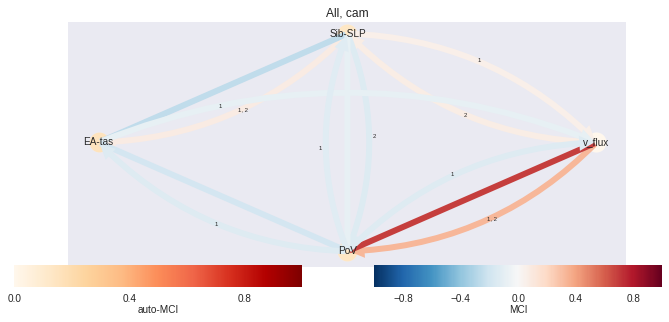

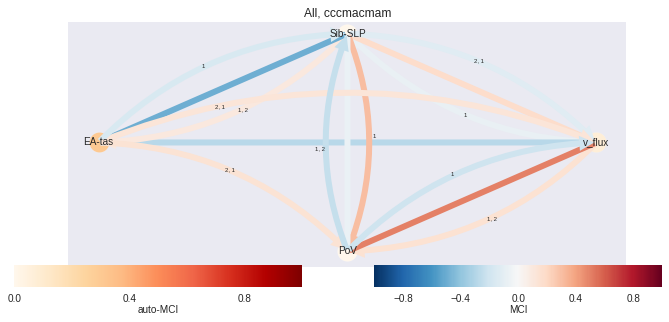

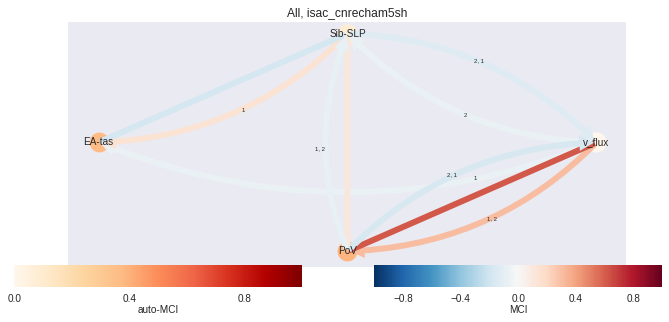

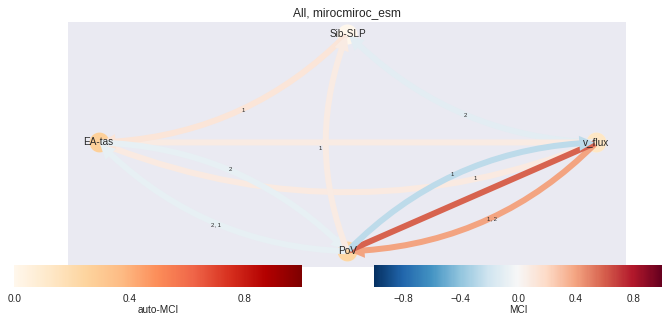

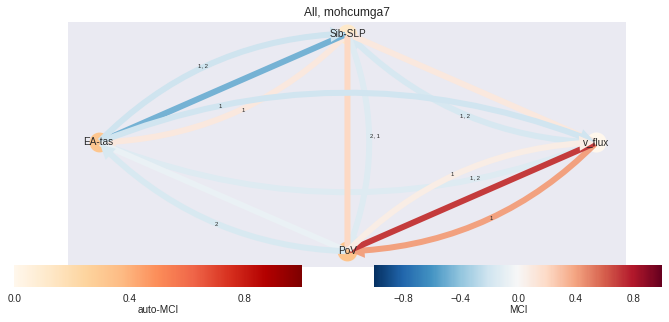

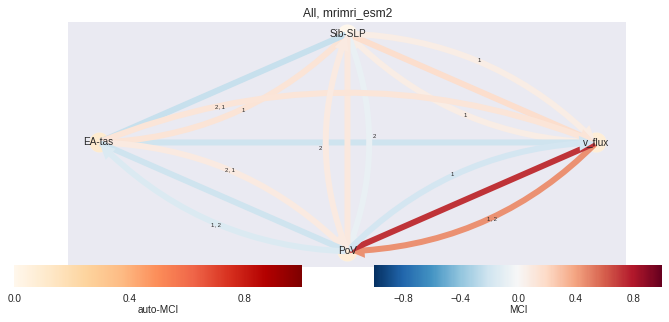

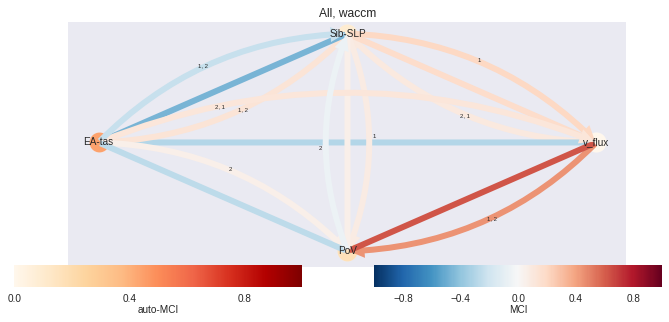

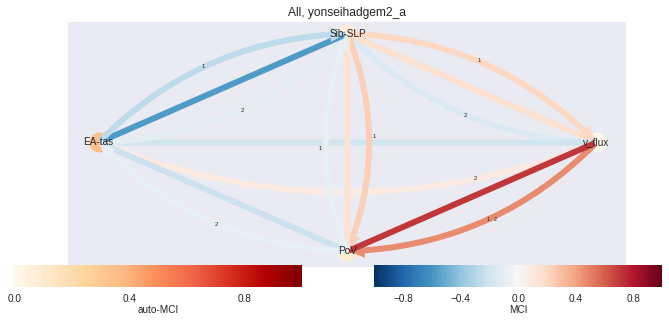

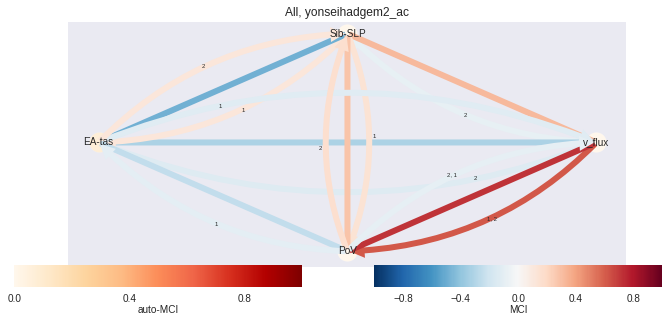

In [54]:
# All available variable names:
# var_names=['NAO','BK-SIC','EA-Snow','PoV','Sib-SLP','Ural-SLP','v_flux']
save_plot=False #True # set to True/False to save the plots to drive folder

#var_select=['EA-Snow','Sib-SLP','v_flux','PoV']
var_select=['v_flux','Sib-SLP','EA-tas','PoV']

print("-----------------------------------------------------")
print("CAM")
plot_model(cam_noqbo,cam_noqbo_mask,cam_qboe_mask,cam_qbow_mask,
           var_select=var_select,save_plot=save_plot,save_name="cam", title="cam")
print("-----------------------------------------------------")
print("CCCMA")
plot_model(cccmacmam_noqbo,cccmacmam_noqbo_mask,cccmacmam_qboe_mask,cccmacmam_qbow_mask,
           var_select=var_select,save_plot=save_plot,save_name="cccmacmam",title="cccmacmam")
print("-----------------------------------------------------")
print("ISAC")
plot_model(isac_cnrecham5sh_noqbo,isac_cnrecham5sh_noqbo_mask,isac_cnrecham5sh_qboe_mask,isac_cnrecham5sh_qbow_mask,
           var_select=var_select,save_plot=save_plot,save_name="isac_cnrecham5sh",title="isac_cnrecham5sh")
print("-----------------------------------------------------")
#print("MIROC AGCM")
#plot_model(mirocmiroc_agcm_noqbo,mirocmiroc_agcm_noqbo_mask,mirocmiroc_agcm_qboe_mask,mirocmiroc_agcm_qbow_mask,
#           var_select=var_select,save_plot=save_plot,save_name="mirocmiroc_agcm",title="mirocmiroc_agcm")
#print("-----------------------------------------------------")
print("MIROC ESM")
plot_model(mirocmiroc_esm_noqbo,mirocmiroc_esm_noqbo_mask,mirocmiroc_esm_qboe_mask,mirocmiroc_esm_qbow_mask,
           var_select=var_select,save_plot=save_plot,save_name="mirocmiroc_esm",title="mirocmiroc_esm")
print("-----------------------------------------------------")
print("MOHC")
plot_model(mohcumga7_noqbo,mohcumga7_noqbo_mask,mohcumga7_qboe_mask,mohcumga7_qbow_mask,
           var_select=var_select,save_plot=save_plot,save_name="mohcumga7",title="mohcumga7")
print("-----------------------------------------------------")
print("MRI")
plot_model(mrimri_esm2_noqbo,mrimri_esm2_noqbo_mask,mrimri_esm2_qboe_mask,mrimri_esm2_qbow_mask,
           var_select=var_select,save_plot=save_plot,save_name="mrimri_esm2",title="mrimri_esm2")
print("-----------------------------------------------------")
print("WACCM")
plot_model(waccm_noqbo,waccm_noqbo_mask,waccm_qboe_mask,waccm_qbow_mask,
           var_select=var_select,save_plot=save_plot,save_name="waccm",title="waccm")
print("-----------------------------------------------------")
print("YONSEI A")
plot_model(yonseihadgem2_a_noqbo,yonseihadgem2_a_noqbo_mask,yonseihadgem2_a_qboe_mask,yonseihadgem2_a_qbow_mask,
           var_select=var_select,save_plot=save_plot,save_name="yonseihadgem2_a",title="yonseihadgem2_a")
print("-----------------------------------------------------")
print("YONSEI AC")
plot_model(yonseihadgem2_ac_noqbo,yonseihadgem2_ac_noqbo_mask,yonseihadgem2_ac_qboe_mask,yonseihadgem2_ac_qbow_mask,
           var_select=var_select,save_plot=save_plot,save_name="yonseihadgem2_ac",title="yonseihadgem2_ac")


### Ensemble mean plots


The code  below calculates the link matrices for all models, then combines them. You can change the models used by changing the "mods" list. Change the actors used by changing the var_select list. Rerun the two cells below to see the changes.



In [0]:
# Function for ensemble plots


def run_and_plot_prepare_ensemble(dataframe, cond_ind_test, tau_max,
                                  tau_min, pc_alpha=0.4):
    """
    small function from example notebook to calc pcmci and plot masked links
    
    """
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)
    results = pcmci.run_pcmci(tau_min=tau_min,tau_max=tau_max,pc_alpha=pc_alpha)
    link_matrix = pcmci.return_significant_parents(pq_matrix=results['p_matrix'],
            val_matrix=results['val_matrix'], alpha_level=pc_alpha)['link_matrix']
# #     tp.plot_graph(fig_ax = fig_ax,  val_matrix=results['val_matrix'],
# #                   link_matrix=link_matrix, var_names=var_select,
#     )
    return results, link_matrix




Current variables: v_flux_BK-SIC_NAO_PoV
ALL YEARS
QBOW YEARS
QBOE YEARS
ALL YEARS


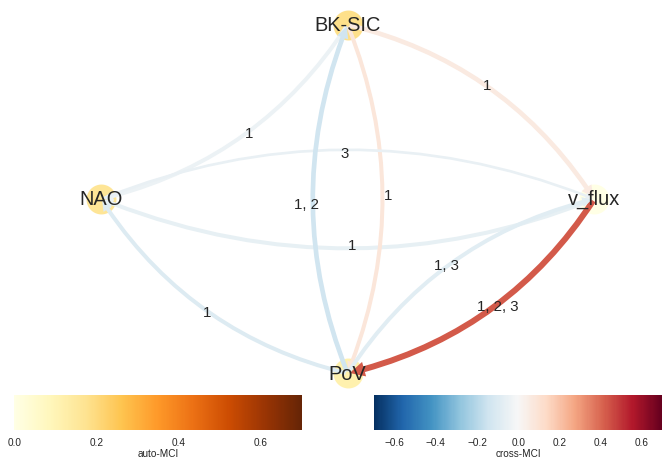

In [29]:
### WORKING QBOE/W MASK
### 

mods = [cam_noqbo,cccmacmam_noqbo,isac_cnrecham5sh_noqbo, #mirocmiroc_agcm_noqbo,
        mirocmiroc_esm_noqbo,mohcumga7_noqbo,mrimri_esm2_noqbo,waccm_noqbo,
        yonseihadgem2_a_noqbo,yonseihadgem2_ac_noqbo]

qemask = [cam_qboe_mask, cccmacmam_qboe_mask, isac_cnrecham5sh_qboe_mask, #mirocmiroc_agcm_qboe_mask,
        mirocmiroc_esm_qboe_mask,mohcumga7_qboe_mask,mrimri_esm2_qboe_mask,waccm_qboe_mask,
        yonseihadgem2_a_qboe_mask,yonseihadgem2_ac_qboe_mask]
qwmask = [cam_qbow_mask, cccmacmam_qbow_mask, isac_cnrecham5sh_qbow_mask, #mirocmiroc_agcm_qbow_mask,
        mirocmiroc_esm_qbow_mask,mohcumga7_qbow_mask,mrimri_esm2_qbow_mask,waccm_qbow_mask,
        yonseihadgem2_a_qbow_mask,yonseihadgem2_ac_qbow_mask]
monmask = [cam_noqbo_mask, cccmacmam_noqbo_mask, isac_cnrecham5sh_noqbo_mask, #mirocmiroc_agcm_noqbo_mask,
        mirocmiroc_esm_noqbo_mask,mohcumga7_noqbo_mask,mrimri_esm2_noqbo_mask,waccm_noqbo_mask,
        yonseihadgem2_a_noqbo_mask,yonseihadgem2_ac_noqbo_mask]


var_select=['NAO','BK-SIC','EA-tas','PoV','Sib-SLP','Ural-SLP'] # ['BK-SIC','EA-Snow','PoV','v_flux','Sib-SLP']
#var_select=['v_flux','Ural-SLP','NAO','PoV'] #,'v_flux']
var_select=['PoV','Ural-SLP']
var_select=['v_flux','BK-SIC','NAO','PoV']

current_var = "_".join(var_select)
print("Current variables: {}".format(current_var))
#var_select=['PoV','Sib-SLP','v_flux']
# all variable names: ['AO','BK-tas','EA-tas','PoV','Sib-SLP','Ural-SLP','v_flux']


# Change these variables
tau_max = 3         # Maximum lag
tau_min = 1         # Minimum lag
robust_thres = 0.5  # Only show links that are significant in that fraction of models
alpha_level = 0.4   # Significance in parent finding step

n_models = len(mods)
n_cols = len(var_select)

link_matrices_all = numpy.zeros((n_models, n_cols, n_cols, tau_max + 1))
average_vals_all = numpy.zeros((n_models, n_cols, n_cols, tau_max + 1))
link_matrices_qe = numpy.zeros((n_models, n_cols, n_cols, tau_max + 1))
average_vals_qe = numpy.zeros((n_models, n_cols, n_cols, tau_max + 1))
link_matrices_qw = numpy.zeros((n_models, n_cols, n_cols, tau_max + 1))
average_vals_qw = numpy.zeros((n_models, n_cols, n_cols, tau_max + 1))

for i in range(n_models):
    
    # Initialize dataframe object
    data = mods[i].as_matrix(columns=var_select)
    
    df_all  = pp.DataFrame(data, mask=monmask[i][:,0:n_cols])
    df_qbow = pp.DataFrame(data, mask= qwmask[i][:,0:n_cols])
    df_qboe = pp.DataFrame(data, mask= qemask[i][:,0:n_cols])
    

    results_all, link_matrix_all = run_and_plot_prepare_ensemble(df_all, 
                                      ParCorr(significance='analytic',mask_type='y'),
                                      tau_max=tau_max,
                                      tau_min=tau_min,
                                      pc_alpha=alpha_level)
    results_qboe, link_matrix_qboe = run_and_plot_prepare_ensemble(df_qboe,
                                      ParCorr(significance='analytic',mask_type='y'),
                                      tau_max=tau_max,
                                      tau_min=tau_min,
                                      pc_alpha=alpha_level)
    results_qbow, link_matrix_qbow = run_and_plot_prepare_ensemble(df_qbow,
                                      ParCorr(significance='analytic',mask_type='y'),
                                      tau_max=tau_max,
                                      tau_min=tau_min,
                                      pc_alpha=alpha_level)

    link_matrices_all[i] = link_matrix_all
    average_vals_all[i] = results_all['val_matrix']
    link_matrices_qw[i] = link_matrix_qbow
    average_vals_qw[i] = results_qbow['val_matrix']
    link_matrices_qe[i] = link_matrix_qboe
    average_vals_qe[i] = results_qboe['val_matrix']


print("ALL YEARS")
link_color_matrix_all = average_vals_all.mean(axis=0)
link_width_all = link_matrices_all.mean(axis=0)
link_matrix_all = link_width_all > robust_thres

print("QBOW YEARS")
link_color_matrix_qw = average_vals_qw.mean(axis=0)
link_width_qw = link_matrices_qw.mean(axis=0)
link_matrix_qw = link_width_qw > robust_thres

print("QBOE YEARS")
link_color_matrix_qe = average_vals_qe.mean(axis=0)
link_width_qe = link_matrices_qe.mean(axis=0)
link_matrix_qe = link_width_qe > robust_thres

## PLOT ENSEMBLE PLOTS

# FIGURE PROPERTIES

savefig = True #False # Save figures in the google drive, True or False

vmax_edges=0.7; vmin_edges=-0.7
vmax_nodes=0.7; vmin_nodes=0.0
edge_ticks=0.2; node_ticks=0.2
cmap_nodes='YlOrBr'; cmap_edges='RdBu_r'
    

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111,frameon=False)
#plt.title("MMM, ONDJFM, monthly")
print("ALL YEARS")
tp.plot_graph(
    val_matrix=link_color_matrix_all,
    fig_ax=(fig,ax),
    link_matrix=link_matrix_all,
    var_names=var_select,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_width_all,
    vmax_edges=vmax_edges,
    vmin_edges=vmin_edges,
    edge_ticks=edge_ticks,
    node_ticks=node_ticks,
    vmax_nodes=vmax_nodes,
    vmin_nodes=vmin_nodes,
    cmap_nodes=cmap_nodes,
    cmap_edges=cmap_edges,
    node_size=30,
    node_label_size=20,
    link_label_fontsize=15,
    arrowhead_size=20,
    arrow_linewidth=30,
    show_colorbar=True
    )

if savefig:
  fig.savefig('modens_mon_{}.png'.format(current_var), bbox_inches='tight')
  figfile = drive.CreateFile({'title':'modens_mon_{}.png'.format(current_var),
                              'parents':[{u'id':'1aN1qG2bb-LFGxQQehtNRQNlVnjt8l-I3'}]})
  # the 'parents' key is set to save in the ./figures/ dir
  figfile.SetContentFile('modens_mon_{}.png'.format(current_var))
  figfile.Upload()



### Make jumbo plots for EGU poster


Current variables: v_flux_Sib-SLP_EA-tas_PoV
ALL YEARS
QBOW YEARS
QBOE YEARS
ALL YEARS


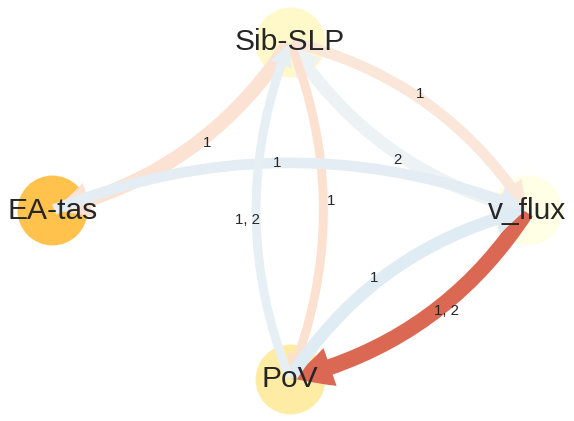

In [23]:
### WORKING QBOE/W MASK
### 

mods = [cam_noqbo,cccmacmam_noqbo,isac_cnrecham5sh_noqbo, #mirocmiroc_agcm_noqbo,
        mirocmiroc_esm_noqbo,mohcumga7_noqbo,mrimri_esm2_noqbo,waccm_noqbo,
        yonseihadgem2_a_noqbo,yonseihadgem2_ac_noqbo]

qemask = [cam_qboe_mask, cccmacmam_qboe_mask, isac_cnrecham5sh_qboe_mask, #mirocmiroc_agcm_qboe_mask,
        mirocmiroc_esm_qboe_mask,mohcumga7_qboe_mask,mrimri_esm2_qboe_mask,waccm_qboe_mask,
        yonseihadgem2_a_qboe_mask,yonseihadgem2_ac_qboe_mask]
qwmask = [cam_qbow_mask, cccmacmam_qbow_mask, isac_cnrecham5sh_qbow_mask, #mirocmiroc_agcm_qbow_mask,
        mirocmiroc_esm_qbow_mask,mohcumga7_qbow_mask,mrimri_esm2_qbow_mask,waccm_qbow_mask,
        yonseihadgem2_a_qbow_mask,yonseihadgem2_ac_qbow_mask]
monmask = [cam_noqbo_mask, cccmacmam_noqbo_mask, isac_cnrecham5sh_noqbo_mask, #mirocmiroc_agcm_noqbo_mask,
        mirocmiroc_esm_noqbo_mask,mohcumga7_noqbo_mask,mrimri_esm2_noqbo_mask,waccm_noqbo_mask,
        yonseihadgem2_a_noqbo_mask,yonseihadgem2_ac_noqbo_mask]


var_select=['NAO','BK-SIC','EA-tas','PoV','Sib-SLP','Ural-SLP'] # ['BK-SIC','EA-Snow','PoV','v_flux','Sib-SLP']
var_select=['v_flux','Sib-SLP','EA-tas','PoV'] #,'v_flux']
#var_select=['PoV','EA-tas']
#var_select=['v_flux','EA-tas','PoV']

current_var = "_".join(var_select)
print("Current variables: {}".format(current_var))
#var_select=['PoV','Sib-SLP','v_flux']
# all variable names: ['AO','BK-tas','EA-tas','PoV','Sib-SLP','Ural-SLP','v_flux']


# Change these variables
tau_max = 2         # Maximum lag
tau_min = 1         # Minimum lag
robust_thres = 0.5  # Only show links that are significant in that fraction of models
alpha_level = 0.4   # Significance in parent finding step

n_models = len(mods)
n_cols = len(var_select)

link_matrices_all = numpy.zeros((n_models, n_cols, n_cols, tau_max + 1))
average_vals_all = numpy.zeros((n_models, n_cols, n_cols, tau_max + 1))
link_matrices_qe = numpy.zeros((n_models, n_cols, n_cols, tau_max + 1))
average_vals_qe = numpy.zeros((n_models, n_cols, n_cols, tau_max + 1))
link_matrices_qw = numpy.zeros((n_models, n_cols, n_cols, tau_max + 1))
average_vals_qw = numpy.zeros((n_models, n_cols, n_cols, tau_max + 1))

for i in range(n_models):
    
    # Initialize dataframe object
    data = mods[i].as_matrix(columns=var_select)
    
    df_all  = pp.DataFrame(data, mask=monmask[i][:,0:n_cols])
    df_qbow = pp.DataFrame(data, mask= qwmask[i][:,0:n_cols])
    df_qboe = pp.DataFrame(data, mask= qemask[i][:,0:n_cols])
    

    results_all, link_matrix_all = run_and_plot_prepare_ensemble(df_all, 
                                      ParCorr(significance='analytic',mask_type='y'),
                                      tau_max=tau_max,
                                      tau_min=tau_min,
                                      pc_alpha=alpha_level)
    results_qboe, link_matrix_qboe = run_and_plot_prepare_ensemble(df_qboe,
                                      ParCorr(significance='analytic',mask_type='y'),
                                      tau_max=tau_max,
                                      tau_min=tau_min,
                                      pc_alpha=alpha_level)
    results_qbow, link_matrix_qbow = run_and_plot_prepare_ensemble(df_qbow,
                                      ParCorr(significance='analytic',mask_type='y'),
                                      tau_max=tau_max,
                                      tau_min=tau_min,
                                      pc_alpha=alpha_level)

    link_matrices_all[i] = link_matrix_all
    average_vals_all[i] = results_all['val_matrix']
    link_matrices_qw[i] = link_matrix_qbow
    average_vals_qw[i] = results_qbow['val_matrix']
    link_matrices_qe[i] = link_matrix_qboe
    average_vals_qe[i] = results_qboe['val_matrix']


print("ALL YEARS")
link_color_matrix_all = average_vals_all.mean(axis=0)
link_width_all = link_matrices_all.mean(axis=0)
link_matrix_all = link_width_all > robust_thres

print("QBOW YEARS")
link_color_matrix_qw = average_vals_qw.mean(axis=0)
link_width_qw = link_matrices_qw.mean(axis=0)
link_matrix_qw = link_width_qw > robust_thres

print("QBOE YEARS")
link_color_matrix_qe = average_vals_qe.mean(axis=0)
link_width_qe = link_matrices_qe.mean(axis=0)
link_matrix_qe = link_width_qe > robust_thres

## PLOT ENSEMBLE PLOTS

# FIGURE PROPERTIES

savefig = False # Save figures in the google drive, True or False

vmax_edges=0.7; vmin_edges=-0.7
vmax_nodes=0.7; vmin_nodes=0.0
edge_ticks=0.2; node_ticks=0.2
cmap_nodes='YlOrBr'; cmap_edges='RdBu_r'
    

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111,frameon=False)
#plt.title("MMM, ONDJFM, monthly")
print("ALL YEARS")
tp.plot_graph(
    val_matrix=link_color_matrix_all,
    fig_ax=(fig,ax),
    link_matrix=link_matrix_all,
    var_names=var_select,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_width_all,
    vmax_edges=vmax_edges,
    vmin_edges=vmin_edges,
    edge_ticks=edge_ticks,
    node_ticks=node_ticks,
    vmax_nodes=vmax_nodes,
    vmin_nodes=vmin_nodes,
    cmap_nodes=cmap_nodes,
    cmap_edges=cmap_edges,
    node_size=70,
    node_label_size=30,
    link_label_fontsize=15,
    arrowhead_size=100,
    arrow_linewidth=80,
    show_colorbar=False
    )

if savefig:
  fig.savefig('poster_modens_mon_{}.png'.format(current_var), bbox_inches='tight')
  figfile = drive.CreateFile({'title':'poster_modens_mon_{}.png'.format(current_var),
                              'parents':[{u'id':'1aN1qG2bb-LFGxQQehtNRQNlVnjt8l-I3'}]})
  # the 'parents' key is set to save in the ./figures/ dir
  figfile.SetContentFile('poster_modens_mon_{}.png'.format(current_var))
  figfile.Upload()



QBOW YEARS


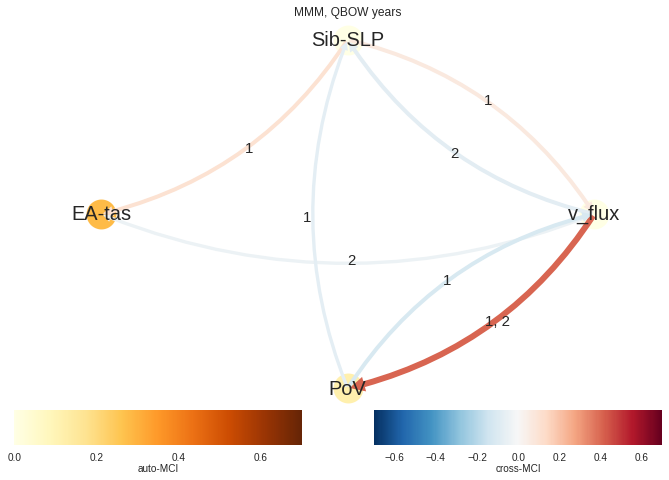

In [26]:
savefig = True

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111,frameon=False)
plt.title("MMM, QBOW years")
print("QBOW YEARS")
tp.plot_graph(
    val_matrix=link_color_matrix_qw,
    fig_ax=(fig,ax),
    link_matrix=link_matrix_qw,
    var_names=var_select,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_width_qw,
    vmax_edges=vmax_edges,
    vmin_edges=vmin_edges,
    edge_ticks=edge_ticks,
    node_ticks=node_ticks,
    vmax_nodes=vmax_nodes,
    vmin_nodes=vmin_nodes,
    cmap_nodes=cmap_nodes,
    cmap_edges=cmap_edges,
    node_size=30,
    node_label_size=20,
    link_label_fontsize=15,
    arrowhead_size=20,
    arrow_linewidth=30,
    show_colorbar=True
    )

if savefig:
  fig.savefig('ens_qbo_w_{}.png'.format(current_var), bbox_inches='tight')
  figfile = drive.CreateFile({'title':'ens_qbo_w_{}.png'.format(current_var),
                              'parents':[{u'id':'1aN1qG2bb-LFGxQQehtNRQNlVnjt8l-I3'}]})
  figfile.SetContentFile('ens_qbo_w_{}.png'.format(current_var))
  figfile.Upload()



QBOE YEARS


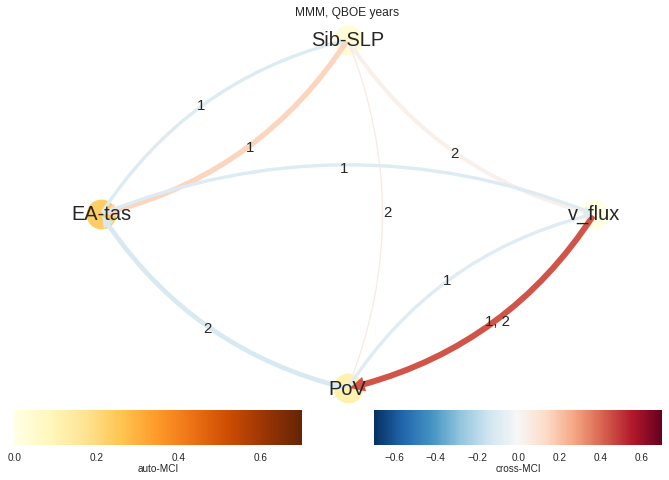

In [25]:
savefig = True

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111,frameon=False)
plt.title("MMM, QBOE years")
print("QBOE YEARS")
tp.plot_graph(
    val_matrix=link_color_matrix_qe,
    fig_ax=(fig,ax),
    link_matrix=link_matrix_qe,
    var_names=var_select,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_width_qe,
    vmax_edges=vmax_edges,
    vmin_edges=vmin_edges,
    edge_ticks=edge_ticks,
    node_ticks=node_ticks,
    vmax_nodes=vmax_nodes,
    vmin_nodes=vmin_nodes,
    cmap_nodes=cmap_nodes,
    cmap_edges=cmap_edges,
    node_size=30,
    node_label_size=20,
    link_label_fontsize=15,
    arrowhead_size=20,
    arrow_linewidth=30,
    show_colorbar=True
    )

if savefig:
  fig.savefig('ens_qbo_e_{}.png'.format(current_var), bbox_inches='tight')
  figfile = drive.CreateFile({'title':'ens_qbo_e_{}.png'.format(current_var),
                              'parents':[{u'id':'1aN1qG2bb-LFGxQQehtNRQNlVnjt8l-I3'}]})
  figfile.SetContentFile('ens_qbo_e_{}.png'.format(current_var))
  figfile.Upload()


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


QBO DIFF: QBOE - QBOW


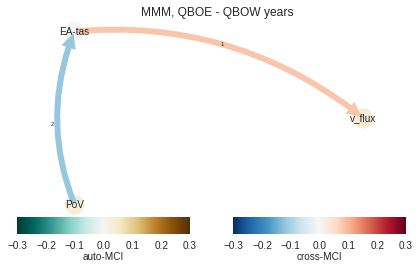

In [32]:

## PLOT ENSEMBLE PLOTS for difference between QBOE-QBOW
fig = plt.figure(1)
ax = plt.subplot(111,frameon=False)
savefig = False #True

link_color_matrix_diff = link_color_matrix_qe - link_color_matrix_qw
link_matrix_diff = link_matrix_qe ^ link_matrix_qw
link_width_diff = np.abs(link_width_qe - link_width_qw)

fig = plt.figure(1)
ax = plt.subplot(111,frameon=False)
plt.title("MMM, QBOE - QBOW years")
print("QBO DIFF: QBOE - QBOW")
tp.plot_graph(
    val_matrix=link_color_matrix_diff,
    fig_ax=(fig,ax),
    link_matrix=link_matrix_diff,
    var_names=var_select,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    vmax_edges=0.3,
    vmin_edges=-0.3,
    edge_ticks=0.1,
    node_ticks=0.1,
    vmax_nodes=0.3,
    vmin_nodes=-0.3,
    cmap_nodes='BrBG_r',
    cmap_edges='RdBu_r'
    )

if savefig:
  fig.savefig('ens_qbo_diff_{}.png'.format(current_var), bbox_inches='tight')
  figfile = drive.CreateFile({'title':'ens_qbo_diff_{}.png'.format(current_var),
                              'parents':[{u'id':'1aN1qG2bb-LFGxQQehtNRQNlVnjt8l-I3'}]})
  figfile.SetContentFile('ens_qbo_diff_{}.png'.format(current_var))
  figfile.Upload()

In the code below I attempted to plot three plots on one figure. Passed the fig and ax to plotting function, bahaviour changed in ver 2, now works - Nick

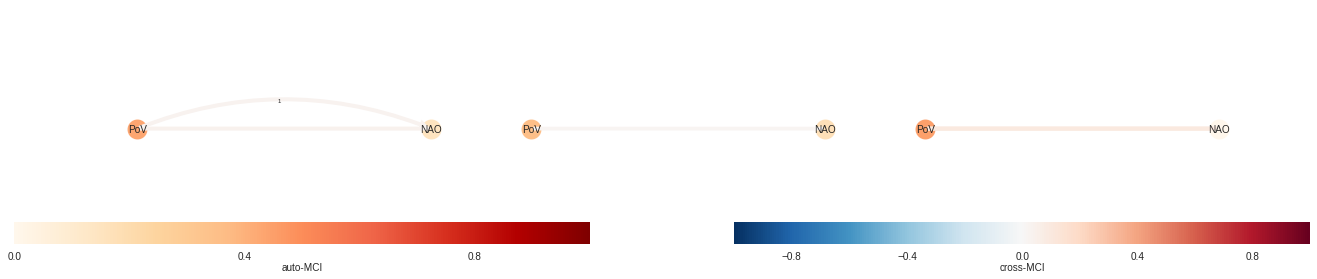

In [0]:
## PLOT ENSEMBLE PLOTS
fig = plt.figure(figsize=(20,5))

#fig = plt.gcf()
ax1 = fig.add_subplot(1,3,1, frameon=False) # should have 1 row, with 3 columns
#ax1 = plt.gca()
#print("ALL YEARS")
tp.plot_graph(
    val_matrix=link_color_matrix_all,
    fig_ax=(fig,ax1),
    link_matrix=link_matrix_all,
    var_names=var_select,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_width_all,
    show_colorbar=False
    )


#fig = plt.gcf()
ax2 = fig.add_subplot(1,3,2, frameon=False)
ax2 = plt.gca()
#print("QBOW YEARS")
tp.plot_graph(
    val_matrix=link_color_matrix_qw,
    fig_ax=(fig,ax2),
    link_matrix=link_matrix_qw,
    var_names=var_select,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_width_qw,
    show_colorbar=False
    )

#fig = plt.gcf()
ax3 = fig.add_subplot(1,3,3, frameon=False)
ax3 = plt.gca()
#print("QBOE YEARS")

out = tp.plot_graph(
    val_matrix=link_color_matrix_qe,
    fig_ax=(fig,ax3),
    link_matrix=link_matrix_qe,
    var_names=var_select,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_width_qe,
    show_colorbar=True
    )


#print(type(out))
#print(type(fig))
#fig.savefig('ens_qbo_e.png', bbox_inches='tight')
#figfile = drive.CreateFile({'title':'ens_qbo_e.png',
#                            'parents':[{u'id':'13BVOh-AHmhzpvS30-eSIvLvhKkYC_01R'}]})
#figfile.SetContentFile('ens_qbo_e.png')
#figfile.Upload()

In [0]:
#Example to save a figure to file
#it will be save in the personal downloads so still need to upload it back to the drive
#import matplotlib.pyplot as plt
#from google.colab import files
#fig = plt.figure()
#ax = fig.add_axes([1,1,1,1])
#plt.plot([1,2])
#plt.savefig('abc.png', bbox_inches='tight')
#files.download("abc.png") 